# Week 4 - Partial Least Squares Regression

In [357]:
import scipy as sp, numpy as np
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
import matplotlib.pyplot as plt

data = sp.io.loadmat('wk4_Cosgrove-data.mat', squeeze_me=True)['s']

X = data['X'].item() # the untransformed data matrix (66x102)
Y = data['Y'].item() # the untransformed LDH release at 48hours. (66x1)
phosphoproteins = data['phosphoproteins'].item() # names of phosphoproteins
conditions = data['conditions'].item() # cell array of the 66 conditions
drugList = data['drugList'].item() # description of the drugs used in each of the 66 conditions
drugListToxic = data['drugListToxic'].item() # binary value corresponding to whether drugList[i] is toxic
drugs = data['drugs'].item() # binary matrix mapping which measurements correspond to a drug treatment in drugList
cytokineList = data['cytokineList'].item() # cell array of cytokine treatments
ind4pProtein = data['ind4pProtein'].item() # the column indices corresponding to measurements of the 4 phosphoprotein subset

In [358]:
# Create function to calculate R^2 values
def R2_(modX, obsX):
    sumSqEr =  np.sum(np.square(np.subtract(obsX, modX)))
#     sumSqObs = np.sum(np.square(np.subtract(obsX, np.mean(obsX))))
    sumSqObs = np.sum(np.square(obsX))
    R2_Val = 1 - sumSqEr / sumSqObs
    
    return R2_Val

#### (1) Perform PLSR on the matrixes X and Y. Plot the percent variance explained. How many principal components do you need for each to explain 90% of the variance? Discuss your findings.

Hint: Be sure to normalize each dataset as needed for the analysis.

Optimal Number of Components = 4
Variance of 92.32 %


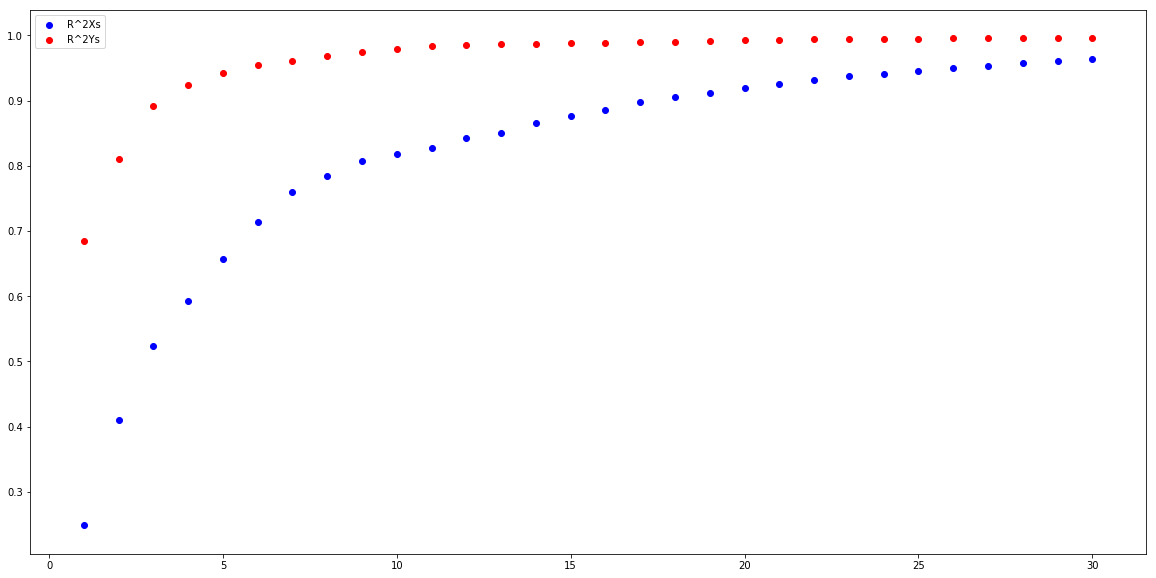

In [359]:
# Answer
from scipy.stats.mstats import zscore 

# Define variables and rename function for PLSR
maxNumPCs = 30
numPCs = np.linspace(1, maxNumPCs, maxNumPCs).astype(int)
maxIter = 500
optNumPCs = -1
Y48 = Y[:, 4]

# Scale X and Y matrices
normX = scale(X)
normY48 = scale(Y48)

# Create arrays for storing R2X and R2Y values
R2Xs = np.zeros(len(numPCs))
R2Ys = np.zeros(len(numPCs))

# Iterate through numbers of PCs and calculate the variance to find when variance of >90% is reached
for i in range(0, len(numPCs)):   
    plsr = PLSRegression(n_components = numPCs[i], scale = True, max_iter = maxIter)
    plsr.fit(normX, normY48)
    scoresX = plsr.x_scores_ 
    loadingsX = plsr.x_loadings_
    
    modelX = np.matmul(scoresX, np.transpose(loadingsX))
    R2Xs[i] = R2_(modelX, normX)
    
    modelY = np.squeeze(plsr.predict(normX))
    R2Ys[i] = R2_(modelY, normY48)
    
    if(optNumPCs < 0 and (R2Xs[i] > 0.9 or R2Ys[i] > 0.9)):
        optNumPCs = numPCs[i]

# Plot the R^2 values with number of PCs used
plt.figure(figsize = (20, 10))
plt.scatter(numPCs, R2Xs, c = 'b')
plt.scatter(numPCs, R2Ys, c = 'r')
plt.legend(labels = ['R^2Xs', 'R^2Ys'])

print("Optimal Number of Components =", optNumPCs)
print("Variance of", round(R2Ys[3] * 100, 3), "%")



#### I found that when 4 principal components are used there is a 92.32% variance in the Y values. In order to achieve a variance of greater thatn 90% for X, 18 principal components should be used. Because we want to use the smallest number of principal components with the highest variance, I chose to use 4 principal components when running pls regression. 

#### (2) Recreate the Figure S2A plot from Cosgrove et al. supplementary information. This is the PLSR scores plot (for PC1 and PC2), with toxic drugs colored according to the drug type and all other drugs are not colored. Use the drugList, drugListToxic to identify these categories.

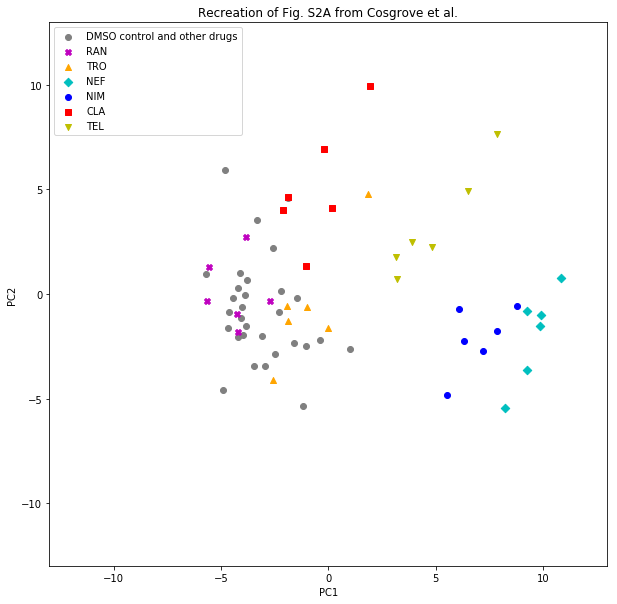

In [360]:
# Answer
# Do PLSR using optimal number of components
plsrOpt = PLSRegression(n_components = optNumPCs, scale = True, max_iter = maxIter)
plsrOpt.fit(normX, normY48)

# print(plsrOpt.x_scores_)

# Store the scores matirx values of PC1 and PC2
scoresXPC1 = plsrOpt.x_scores_[:, 0]
scoresXPC2 = plsrOpt.x_scores_[:, 1]

# Plot the PC values against each other
plt.figure(figsize = (10, 10))
colors = ['gray', 'm', 'orange', 'c', 'b', 'r', 'y']
shape = ['o', 'X', '^', 'D', 'o', 's', 'v']
labels = ['RAN', 'TRO', 'NEF', 'NIM', 'CLA', 'TEL'] 
toxicDrugsIndex = 0

toxicIndices = np.asarray(np.where(drugListToxic == 1))
nontoxicDrugsIndices = np.asarray(np.where(drugListToxic == 0))

# Create ranges for data within scores matrix
nontoxicData = np.asarray(list(range(0, 12)) + list(range(18, 24)) + list(range(30, 36)) + list(range(42, 48)))
RANData = np.asarray(list(range(12, 18)))
TROData = np.asarray(list(range(24, 30)))
NEFData = np.asarray(list(range(36, 42)))
NIMData = np.asarray(list(range(48, 54)))
CLAData = np.asarray(list(range(54, 60)))
TELData = np.asarray(list(range(60, 66)))

plt.scatter(scoresXPC1[nontoxicData], scoresXPC2[nontoxicData], marker = shape[0], c = colors[0], label = 'DMSO control and other drugs')
plt.scatter(scoresXPC1[RANData], scoresXPC2[RANData], marker = shape[1], c = colors[1], label = 'RAN')
plt.scatter(scoresXPC1[TROData], scoresXPC2[TROData], marker = shape[2], c = colors[2], label = 'TRO')
plt.scatter(scoresXPC1[NEFData], scoresXPC2[NEFData], marker = shape[3], c = colors[3], label = 'NEF')
plt.scatter(scoresXPC1[NIMData], scoresXPC2[NIMData], marker = shape[4], c = colors[4], label = 'NIM')            
plt.scatter(scoresXPC1[CLAData], scoresXPC2[CLAData], marker = shape[5], c = colors[5], label = 'CLA')
plt.scatter(scoresXPC1[TELData], scoresXPC2[TELData], marker = shape[6], c = colors[6], label = 'TEL')
                     
plt.title("Recreation of Fig. S2A from Cosgrove et al.")
plt.legend()
plt.xlim(-13, 13)
plt.ylim(-13, 13)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


#### (3) Create the loadings plot corresponding to (2). Interpret the results shown on the plot.

[34, 37, 79, 85]


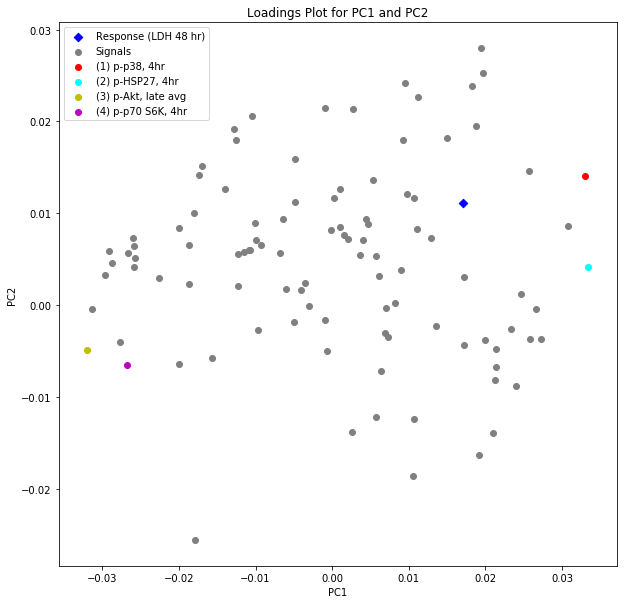

In [361]:
# Answer
# Store the loadings matirx values of PC1 and PC2
# print(plsrOpt.x_loadings_)
weightsYPC1 = plsrOpt.y_weights_[:, 0]
weightsYPC2 = plsrOpt.y_weights_[:, 1]

loadingsYPC1 = plsrOpt.y_loadings_[:, 0]
loadingsYPC2 = plsrOpt.y_loadings_[:, 1]

weightsXPC1  = plsrOpt.x_weights_[:, 0]
weightsXPC2  = plsrOpt.x_weights_[:, 1]

# Find indices of phosoproteins
myPhoprotIndices = []
otherPhoprotIndices = []
myPhosphoproteins = ['p-p38_4hr', 'p-HSP27_4hr', 'p-Akt_lateAvg', 'p-p70 S6K_4hr']
for i in range(0, len(phosphoproteins)):
    if (phosphoproteins[i] in myPhosphoproteins):
        myPhoprotIndices.append(i)
    else:
        otherPhoprotIndices.append(i)

print(myPhoprotIndices)        
# Plot the PC values against each other
plt.figure(figsize = (10, 10))
plt.scatter(0.1 * loadingsYPC1, 0.1 * loadingsYPC2, marker = 'D', c = 'b', label = 'Response (LDH 48 hr)')
plt.scatter(np.multiply(weightsXPC1, weightsYPC1)[otherPhoprotIndices], np.multiply(weightsXPC2, weightsYPC2)[otherPhoprotIndices], c = 'gray', label = 'Signals')

plt.scatter(np.multiply(weightsXPC1, weightsYPC1)[79], np.multiply(weightsXPC2, weightsYPC2)[79], c = 'r', label = '(1) p-p38, 4hr')
plt.scatter(np.multiply(weightsXPC1, weightsYPC1)[85], np.multiply(weightsXPC2, weightsYPC2)[85], c = 'cyan', label = '(2) p-HSP27, 4hr')
plt.scatter(np.multiply(weightsXPC1, weightsYPC1)[34], np.multiply(weightsXPC2, weightsYPC2)[34], c = 'y', label = '(3) p-Akt, late avg')
plt.scatter(np.multiply(weightsXPC1, weightsYPC1)[37], np.multiply(weightsXPC2, weightsYPC2)[37], c = 'm',label = '(4) p-p70 S6K, 4hr')

plt.title("Loadings Plot for PC1 and PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

#### From the loadings plot, the LDH response is most associated with a positive PC1 and PC2. This means that other phosoproteins, with a positive PC1 and PC2, such as p-p38, 4hr, are associated with a LDH response. Additionally, those phosoproteins that have a negative PC1 and PC2 are negatively correlated with a LDH response. Also, looking at the scores plot, it appears that the toxic drugs are associated with a positive PC1 and PC2.

#### (4) Recreate a 4-principal component model using PLSR with just the final 4 phosphoprotein model. Plot predicted v. observed LDH for this model. Report the model fitness ($R^2$). Define here how you are calculating $R^2$.

R^2Y = 88.22 %


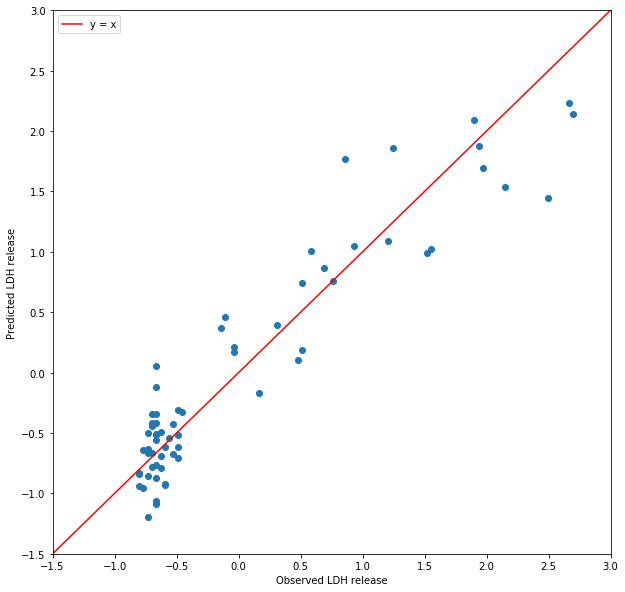

In [362]:
# Answer
# Create new matrix with new phosphoprotein data
fourPhosphoproteinX = X[:, ind4pProtein]
norm4X = scale(fourPhosphoproteinX)

# Create model and predict Y using model trained off of new X
plsr4 = PLSRegression(n_components = 4, scale = True, max_iter = maxIter)
plsr4.fit(norm4X, normY48)

model4Y = np.squeeze(plsr4.predict(norm4X))

# Plot y = x line for reference
plt.figure(1, figsize = (10, 10))
plt.plot([-1.5, 3], [-1.5, 3], c = 'r', label = 'y = x')

# Calculate R^2 value using function written earlier
R2YVal = R2_(model4Y, normY48)
print('R^2Y =', round(R2YVal * 100, 2), "%")

plt.scatter(normY48, model4Y)
plt.xlabel('Observed LDH release')
plt.ylabel('Predicted LDH release')
plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)
plt.legend()
plt.show()


#### R^2 is defined as 1 minus the ratio of the sum of squares of prediction error to the sum of squares of the observed values. There is a function defined at the beginning of the notebook where R2_ is defined.

#### (6) Cosgrove *et al* discusses their method for model validation using leave-one-out cross-validation. Calculate all LDH predictions for leave-one-out cross-validation and calculate the R^2 value for the resulting yfit values. What is the R^2 value? Why do you think it’s important to perform cross-validation?

In [363]:
# Answer
loo = LeaveOneOut()
plsrLOO = PLSRegression(n_components = 4)

# Make arrays to store model Y and observed Y
yObsLOO = []
yModLOO = []

Y48 = np.squeeze(Y48)

for train_index, test_index in loo.split(X, Y48):
    # Isolate test and training data
    xTrainLOO, xTestLOO = X[train_index], X[test_index]
    yTrainLOO, yTestLOO = Y48[train_index], Y48[test_index]
    
    # Fit model to training data
    plsrLOO.fit_transform(xTrainLOO, yTrainLOO)
    plsrLOO.transform(xTestLOO)
    
    yPredictLOO = plsrLOO.predict(xTestLOO)
    
    # Add data to array
    yModLOO.append(yPredictLOO)
    yObsLOO.append(yTestLOO)

# Calculate and show R^2 value
R2YLOO = R2_(np.squeeze(yModLOO), np.squeeze(yObsLOO))   
print('R^2Y =', round(R2YLOO * 100, 2), "%")
    
    

R^2Y = 92.47 %


#### Cross validation is the most important process when building your model. It indicates to you whether or not your model has a good prediction error. If your model was over fit to your training data, it would not be able to accurately predict the test data. Predicting future values is the reason why we use models, so if it is not good at predicting then the model has little use. CV indicates that the model will be useful for predicting values.

#### (7) Now, instead of performing LOOCV, let's perform leave-one-cytokine-out cross-validation. That is, one cytokine at a time, leave out all the data for the `NoCyt`, `IL-1`, `LPS`, `TNF`, `IL-6`, or `Mix` conditions.

Hint: Look at `sklearn.model_selection.LeaveOneGroupOut`.

How does this affect your cross-validation? How do the two approaches here differ? When might each be most appropriate?

In [364]:
# Answer
print(cytokineList)

# Make an array that goes through 0 - 5 11 times
groups = []
for i in range(0, X.shape[0]):
    groups.append(i % 6)

logo = LeaveOneGroupOut()
plsrLOGO = PLSRegression(n_components = 4)

# Make arrays to store model Y and observed Y
yObsLOGO = []
yModLOGO = []


for train_index, test_index in logo.split(X, groups = groups):
    xTrainLOGO, xTestLOGO = X[train_index], X[test_index]
    yTrainLOGO, yTestLOGO = Y48[train_index], Y48[test_index]
    
    # Fit model to training data
    plsrLOGO.fit_transform(xTrainLOGO, yTrainLOGO)
    plsrLOGO.transform(xTestLOGO)
    
    yPredictLOGO = plsrLOGO.predict(xTestLOGO)
    # Add data to array
    yModLOGO.append(np.squeeze(yPredictLOGO))
    yObsLOGO.append(yTestLOGO)

# Put the model data into an array
yModLOGO = np.squeeze(yModLOGO)
yObsLOGO = np.squeeze(yObsLOGO)
yNewModLOGO = []
yNewObsLOGO = []

for i in range(11):
    for j in range(6):
        yNewModLOGO.append(yModLOGO[j][i])
        yNewObsLOGO.append(yObsLOGO[j][i])

# Calculate and show R^2 value
R2YLOGO = R2_(np.squeeze(yNewModLOGO), np.squeeze(yNewObsLOGO))   
print('R^2Y =', round(R2YLOGO * 100, 2), "%")

['NoCyt' 'IL-1' 'LPS' 'TNF' 'IL-6' 'Mix']
R^2Y = 93.2 %


#### The leave-one-cytokine-out cv method yielded a slightly higher R^2 value than that of the leave-one-out method in (6). This indicates that both methods are acceptable when performing cross validation on your model. The methods differed in that the leave-one-cytokine-out method we would separate our test and train data based on the cytokine used in the experiment, while the cv method in (6) does not consider the cytokine used. I would want to use the leave-one-cytokine-out method for models that may have some dependence on the type of cytokine, or group, used in the experiment. If the cytokines did have an effect on the model in anyway it would be hidden when doing loo cross validation because while one member of the group is left, there are 5 other members that are affecting the model and betas of the model. The loo cv method would be ideal for models that have no crossing effects on "independent" data points. 